# Model building

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import plot_roc_curve, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_orig = pd.read_csv("df_processed.csv")
df_orig.replace(np.nan, "no_text", inplace=True)

In [4]:
df_orig.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
0,0,koaw8g,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,https://www.reddit.com/r/finance/comments/koaw...,1609505868,no_text,koaw8g,[deleted],...,1.0,deleted,top seven companies added trillion value,obrocheetah,finance,deleted top seven companies added trillion value,deleted obrocheetah,top seven companies added trillion value obroc...,deleted top seven companies added trillion val...,deleted top seven companies added trillion val...
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...


In [5]:
df_orig.columns

Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'subreddit_processed',
       'body_and_title', 'body_and_author', 'title_and_author',
       'body_title_and_author', 'body_title_author_subreddit'],
      dtype='object')

In [6]:
df = df_orig[["subreddit", "score",
          'body_processed','title_processed', 'author_processed',
          'body_and_title', 'body_and_author', 'title_and_author',
          'body_title_and_author','body_title_author_subreddit'
         ]]

df.head(2)

,subreddit,score,body_processed,title_processed,author_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
0,finance,1,deleted,top seven companies added trillion value,obrocheetah,deleted top seven companies added trillion value,deleted obrocheetah,top seven companies added trillion value obroc...,deleted top seven companies added trillion val...,deleted top seven companies added trillion val...
1,finance,1,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...


# Binarize the Score

- Looking into the score distribution barely going above 0 give  us a 60/40 splits.
- So, convert the score into less than or equal to 1 or bigger than 1
- name that column `score_label`

In [8]:
def binarize_score(df, threshold):
    df["score_label_th_"+str(threshold)] = df["score"].apply(lambda x: int(x>threshold))
    return df

In [9]:
df_ = binarize_score(df_, 1000)

In [10]:
df_.head(2)

,subreddit,score,body_processed,title_processed,author_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,score_label_th_1000
0,finance,1,deleted,top seven companies added trillion value,obrocheetah,deleted top seven companies added trillion value,deleted obrocheetah,top seven companies added trillion value obroc...,deleted top seven companies added trillion val...,0
1,finance,1,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,0


## Saving the test data

In [11]:
df, df_test_ = train_test_split(df_, test_size=0.2,
                                stratify=df_['score_label_th_1000'],
                                random_state = 8848)


In [12]:
# Label distribution
count_0_1=df.groupby("score_label_th_1000").count()['subreddit'].values
print (f"Class 0 {np.round(100*count_0_1[0]/np.sum(count_0_1), 2)} %")
print (f"Class 1 {np.round(100*count_0_1[1]/np.sum(count_0_1), 2)} %")


Class 0 99.0 %
Class 1 1.0 %


## TFIDF Vectorizer

In [18]:
def prepare_vectors(df, feature_col, target_col, tfidf=True):
    df = df[[feature_col, target_col]]
    
    df_train, df_test = train_test_split(df, test_size=0.2,
                                         stratify=df[target_col],
                                         random_state = 8848)
    
    if tfidf:
        vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)
    else:
        vectorizer = CountVectorizer(max_df=0.95)
        
    vectorizer.fit_transform(df_train[feature_col].values)
    
    X_train = vectorizer.transform(df_train[feature_col].values)
    X_test  = vectorizer.transform(df_test[feature_col].values)

    y_train = df_train[target_col].values
    y_test  = df_test[target_col].values

    return X_train, X_test, y_train, y_test, vectorizer

## Logistic Regression models

In [15]:
columns = ["Accuracy", "Pr_0", "Pr_1", "Re_0", "Re_1", "F1_0", "F1_1"]
df_res = pd.DataFrame([], columns = columns)

In [16]:
# A dataframe to store results
def update_results(df_res, model, X, y, model_name):
    ypred = model.predict(X)
    ac = accuracy_score(y.ravel(), ypred.ravel() )
    pr, re, f1, _ = precision_recall_fscore_support(y.ravel(), ypred.ravel() )
    df_res.loc[model_name, "Accuracy"] = np.round(100*ac, 2)
    df_res.loc[model_name, ["Pr_0", "Pr_1"]] = np.round(100*pr, 2)
    df_res.loc[model_name, ["Re_0", "Re_1"]] = np.round(100*re, 2)
    df_res.loc[model_name, ["F1_0", "F1_1"]] = np.round(100*f1, 2)
    return df_res

In [17]:
def print_metrics(model, X, y):
    pred = model.predict(X)
    conf = confusion_matrix(y, pred)
    ac   = accuracy_score(y, pred)
    pr, re, f1, _ = precision_recall_fscore_support(y, pred)
    
    print ("Confusion Matrix:\n", conf)
    print (f"Accuracy Score: {np.round(100*ac,2)}")
    print (f"Precision Score: {np.round(100*pr,2)}")
    print (f"Recall Score: {np.round(100*re,2)}")
    print (f"F1 Score: {np.round(100*f1,2)}")


In [16]:
xcol="body_and_title";
ycol="score_label_th_1000"

X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            xcol,
                                                            ycol)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

In [ ]:
pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

### predict a new post


In [ ]:
import pickle

In [ ]:
with open("vectorizer.pkl", 'wb') as fvec:
    pickle.dump(vectorizer, fvec)


In [ ]:
with open("model_test.pkl", 'wb') as fmod:
     pickle.dump(model, fmod)

In [ ]:
## Load the model and vectorizer

with open("vectorizer.pkl", 'rb') as fvec:
    vect = pickle.load(fvec)

with open("model_test.pkl", 'rb') as fmod:
    saved_model = pickle.load(fmod)

In [ ]:
import praw
reddit = praw.Reddit(
    client_id="kxbUr-4PyE7DlQ",
    client_secret="Q5rIAPS9IHZ1QgOIkHNY09Y9VMxDsA",
    password="AACAXZDE",
    user_agent="testscript by u/kc_the_scraper",
    username="kc_the_scraper",
)

In [ ]:
in1 = "https://www.reddit.com/r/science/comments/ng11s2/meat_eaters_wilfully_disregard_factory_farming_as/"
in3 = "https://www.reddit.com/r/postsreddit/comments/jjuci1/do_people_engage_more_when_you_post_an_earnest/"

In [ ]:
Sub = reddit.submission(url = in3)

In [ ]:
Sub.score

In [ ]:
Sub = reddit.submission(url = in3)
data={'score':[Sub.score],
          'body':[Sub.selftext],
          'created_utc': [Sub.created_utc],
          'ext_link': [Sub.url],
          'title':[Sub.title],
          'subreddit':[Sub.subreddit.display_name],
          'upvote_ratio':[Sub.upvote_ratio],
          'author':[Sub.author.name],
          'original_url':[in3]}
data

In [ ]:
df_in = pd.DataFrame(data, index=None)

In [ ]:
df_in

In [ ]:
def get_reddit_info(url):
    Sub = reddit.submission(url = url)
    data={'score':[Sub.score],
              'body':[Sub.selftext],
              'created_utc': [Sub.created_utc],
              'ext_link': [Sub.url],
              'title':[Sub.title],
              'subreddit':[Sub.subreddit.display_name],
              'upvote_ratio':[Sub.upvote_ratio],
              'author':[Sub.author.name],
              'original_url':[url]}
    return pd.DataFrame(data, index=None)
        
df_in=get_reddit_info(in1)

In [ ]:
#from prepare_text import get_processed_data
in3 = "https://www.reddit.com/r/postsreddit/comments/jjuci1/do_people_engage_more_when_you_post_an_earnest/"

with open("vectorizer.pkl", 'rb') as fvec:
    vect2 = pickle.load(fvec)

In [ ]:
XX= df_prepared["body_and_title"]

In [ ]:
vect2.transform(XX)

In [ ]:
df_prepared

In [ ]:
xcol="body_and_title";
ycol="score_label"
X_tfidf = vectorizer.transform(df_prepared[xcol].values)

In [ ]:
ypred = model.predict(X_tfidf)

In [ ]:
ypred[0]

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
return model, X_train, X_test, y_train, y_test

In [ ]:
model, X_train, X_test, y_train, y_test = logistic_regression()
df_res = update_results(df_res, model, X_test, y_test, 'LR : Title + Body')
df_res

In [ ]:
def logistic_regression(df=df, xcol="body_processed", ycol="score_label"):
    X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                                xcol,
                                                                ycol)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test

## Logistic Regression with Body only

In [ ]:
model, X_train, X_test, y_train, y_test = logistic_regression(xcol="body_processed")
df_res = update_results(df_res, model, X_test, y_test, 'LR : Body Only')
df_res

In [ ]:
model, X_train, X_test, y_train, y_test = logistic_regression(xcol="body_processed")
df_res = update_results(df_res, model, X_test, y_test, 'LR : Body Only')
df_res

In [ ]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
conf_matrix

## Logistic Regression with Title only

In [ ]:
model, X_train, X_test, y_train, y_test = logistic_regression(xcol="title_processed")
df_res = update_results(df_res, model, X_test, y_test, 'LR : Title Only')
df_res

## Logistic Regression with Title + Body

In [ ]:
model, X_train, X_test, y_train, y_test = logistic_regression(xcol="body_and_title")
df_res = update_results(df_res, model, X_test, y_test, 'LR : Title + Body')
df_res

## Logistic Regression with Title + Body + author

In [ ]:
model, X_train, X_test, y_train, y_test = logistic_regression(xcol="body_title_and_author")
df_res = update_results(df_res, model, X_test, y_test, 'LR : Title + Body + Author')
df_res

In [ ]:
# save LR results
dftmp = df_res.drop(["SVM: Body only [CV]", "SVM: Title + Body [CV]"] , axis=0)

In [ ]:
dftmp.to_csv("df_res_LR.csv")

## Logistic Regression Results
| Method | Accuracy | Pr_0 | Pr_1 | Re_0 | Re_1 | F1_0 | F1_1 | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| LR : Body Only | 71.82 | 65.29 | 76.43 | 66.11 | 75.77 | 65.7 | 76.09 | 
| LR : Title Only | 68.76 | 67.75 | 69.14 | 44.77 | 85.3 | 53.92 | 76.37 | 
| LR : Title + Body | 75.52 | 73.54 | 76.58 | 62.52 | 84.49 | 67.58 | 80.34 | 
| LR : Title + Body + Author | 81.21 | 80.59 | 81.56 | 71.08 | 88.19 | 75.54 | 84.75 | 

## Support Vector Machine

In [ ]:
# load the LR results
#df_res = pd.read_csv('df_res_LR.csv')
#df_res.set_index("Method", drop=True, inplace=True)
#df_res

In [ ]:
xcol="body_processed";
ycol="score_label"
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            xcol,
                                                            ycol)



In [ ]:
def grid_search_CV_SVM(params, df=df, xcol="body_processed", ycol="score_label", N_cv=5):
    X_train, X_test, y_train, y_test, vectorizer = prepare_TFIDF(df,
                                                                xcol,
                                                                ycol)
    
    model_grid = GridSearchCV(estimator = SVC(kernel='rbf', degree=3, max_iter=1000),
                              param_grid = params,
                              cv = StratifiedKFold(n_splits=N_cv,
                                                   random_state=8848,
                                                   shuffle=True),
                              verbose=3)
    grid_res = model_grid.fit(X_train, y_train)
    print ( "Best Score:", grid_res.best_score_, grid_res.best_params_)
    return model_grid, X_train, X_test, y_train, y_test, grid_res

In [ ]:
params = {"C":[5, 10, 15]}

model_grid, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_SVM(params,
                                                                            xcol="body_processed")

In [ ]:
df_res = update_results(df_res, model_grid, X_test, y_test, 'SVM: Body only [CV]')
df_res

In [ ]:
params = {"C":[5, 10]}

model_grid, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_SVM(params,
                                                                            xcol="body_and_title")

df_res = update_results(df_res, model_grid, X_test, y_test, 'SVM: Title + Body [CV]')
df_res

In [ ]:
pred=model_grid.predict(X_test)

In [ ]:
sum(pred), len(pred)

In [ ]:
model_svm = SVC(C=10.0, kernel='rbf',
                degree=3, gamma='scale',
                max_iter=1000)
model_svm.fit(X_train, y_train)
pred = model_svm.predict(X_test)
print ( accuracy_score(y_test, pred),
       pred.sum(),
       y_test.sum()
      )

In [ ]:
print ( accuracy_score(y_train, model_svm.predict(X_train)) )

In [ ]:
def train_SVM(df=df, xcol="body_processed", ycol="score_label"):
    X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                                xcol,
                                                                ycol)

    model_svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', max_iter=500)
    model_svm.fit(X_train, y_train)
    return model_svm, X_train, X_test, y_train, y_test


In [ ]:
model_svm, X_train, X_test, y_train, y_test = train_SVM(df=df, xcol="body_processed")

In [ ]:
model_svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', max_iter=500)
model_svm.fit()

# Decision Trees

In [ ]:
def decision_tree(df=df, xcol="body_processed", ycol="score_label"):
    X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                                xcol,
                                                                ycol)
    model = DecisionTreeClassifier(random_state = 8848, max_depth=2)
    model.fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test

## Decision Tree with Body + Title + Author

In [ ]:
model, X_train, X_test, y_train, y_test = decision_tree(xcol="body_title_and_author")

In [ ]:
model, X_train, X_test, y_train, y_test = decision_tree(xcol="body_title_and_author")
df_res = update_results(df_res, model, X_train, y_train, 'DT : Title + Body + Author')
df_res

## Decision Tree : Cross Validation

In [ ]:
def grid_search_CV(params, df=df, xcol="body_processed", ycol="label", N_cv=5):
    X_train, X_test, y_train, y_test, vectorizer = prepare_TFIDF(df,
                                                                xcol,
                                                                ycol)
    
    model_grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 8848),
                              param_grid = params,
                              cv = StratifiedKFold(n_splits=N_cv,
                                                   random_state=8848,
                                                   shuffle=True),
                              verbose=3)
    grid_res = model_grid.fit(X_train, y_train)
    print ( "Best Score:", grid_res.best_score_, grid_res.best_params_)
    return model_grid, X_train, X_test, y_train, y_test, grid_res

## Decision Tree : CV, Body Only

In [ ]:
params = {"max_depth": [4, 5, 6] }
model, X_train, X_test, y_train, y_test, grid_res = grid_search_CV(params,
                                                                   xcol="body_processed")
df_res = update_results(df_res, model, X_train, y_train, 'DT : Body Only [CV]')
df_res

In [ ]:
params = {"max_depth": [4, 5, 6, 10, 20] }
model, X_train, X_test, y_train, y_test, grid_res = grid_search_CV(params,
                                                                   xcol="title_processed")
df_res = update_results(df_res, model, X_train, y_train, 'DT : Title Only [CV]')
df_res

In [ ]:
params = {"max_depth": [10, 15, 20, 25] }
model, X_train, X_test, y_train, y_test, grid_res = grid_search_CV(params,
                                                                   xcol="title_processed")


# Decision Trees

In [ ]:
# Body only
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "body_processed",
                                                            "label")

model = DecisionTreeClassifier(random_state = 8848)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'DT : Body Only')
df_res

In [ ]:
# Title only
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "title_processed",
                                                            "label")

model = DecisionTreeClassifier(random_state = 8848)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'DT : Title Only')
df_res

In [ ]:
# Body + Title only
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "body_and_title",
                                                            "label")

model = DecisionTreeClassifier(random_state = 8848)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'DT : Title + Body')
df_res

# Decision Tree: Grid Search CV

In [ ]:
def grid_search_CV(model, params, X_train, y_train):
    #max_depths = 
    #
    model_grid = GridSearchCV(estimator = model,
                              param_grid = params,
                              cv = StratifiedKFold(n_splits=5, random_state=8848, shuffle=True), 
                              verbose=2)
    grid_res = model_grid.fit(X_train, y_train)
    print ( "Besy Score:", grid_res.best_score_, grid_res.best_params_)
    return grid_res

In [ ]:
model = DecisionTreeClassifier(random_state = 8848)
params = {"max_depth": [5, 6, 7, 8] }
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "title_processed",
                                                            "label")

grid_res = grid_search_CV(model, params, X_train, y_train)

In [ ]:
model = DecisionTreeClassifier(random_state = 8848, max_depth=6)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'DT : Title Only [CV]')
df_res

## Decision Tree: Grid Search CV Title + Body

In [ ]:
model = DecisionTreeClassifier(random_state = 8848)
params = {"max_depth": [7, 8, 9, 10] }
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "body_and_title",
                                                            "label")

grid_res = grid_search_CV(model, params, X_train, y_train)

In [ ]:
model = DecisionTreeClassifier(random_state = 8848, max_depth=9)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'DT : Title + Body [CV]')
df_res

In [ ]:
model = DecisionTreeClassifier(random_state = 8848)
params = {"max_depth": [7, 8, 9, 10] }
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "body_processed",
                                                            "label")
grid_res = grid_search_CV(model, params, X_train, y_train)

In [ ]:
model = DecisionTreeClassifier(random_state = 8848, max_depth=9)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'DT : Body Only [CV]')
df_res

## Random Forest

In [ ]:
# Body only
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "body_processed",
                                                            "label")

model = RandomForestClassifier(random_state = 8848)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'RF : Body Only')
df_res

## Random Forest : Grid Search CV

In [ ]:
model = RandomForestClassifier(random_state = 8848)
params = {"max_depth": [7, 8], "n_estimators":[100, 200] }
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "body_processed",
                                                            "label")

grid_res = grid_search_CV(model, params, X_train, y_train)

In [ ]:
model = RandomForestClassifier(random_state = 8848)
params = {"max_depth": [8, 9, 10], "n_estimators":[200, 300] }
X_train, X_test, y_train, y_test, vectorizer= prepare_TFIDF(df,
                                                            "body_processed",
                                                            "label")

grid_res = grid_search_CV(model, params, X_train, y_train)

In [ ]:
# Body only
model = RandomForestClassifier(random_state = 8848, max_depth= 10, n_estimators=300)
model.fit(X_train, y_train)
df_res = update_results(df_res, model, X_train, y_train,'RF : Body Only [CV]')
df_res

**Few words:**
- The GridSearchCV takes the default score as *accuracy* I guess.
- We may have to use a differnt scoring as well.

## Popular as 95 percentile

In [23]:
df_superstocks = df[df.subreddit == 'Superstonks']
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

In [24]:
df_superstocks['popular'] = 0
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

In [25]:
df_superstocks.loc[df_superstocks['score'] > np.percentile(df_superstocks.score.values, 95), 'popular'] = 1
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

In [26]:
df = pd.concat([df_superstocks, df_finance, df_options,
                df_pennystocks, df_gme], ignore_index=True)

In [27]:
df = df[(df.body_processed != 'deleted') & (df.body_processed != 'removed')]

In [28]:
df.head(2)

,subreddit,score,body_processed,title_processed,author_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit,popular
1,Superstonks,81,r superstonk,sub looking r superstonk,seppukkake,r superstonk sub looking r superstonk,r superstonk seppukkake,sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukka...,1
2,Superstonks,15,no_text,https www reddit com r superstonk,fairytalee,no_text https www reddit com r superstonk,no_text fairytalee,https www reddit com r superstonk fairytalee,no_text https www reddit com r superstonk fair...,no_text https www reddit com r superstonk fair...,0


In [20]:
def grid_search_CV_LR(params, df=df,
                      xcol="body_processed",
                      ycol="score_label",
                      N_cv=5,
                      wt_factor=1,
                      scorer = "precision",
                      verbose = 0,
                      tfidf=True
                     ):
    
    X_train, X_test, y_train, y_test, vectorizer = prepare_vectors(df,
                                                                   xcol,
                                                                   ycol,
                                                                   tfidf=tfidf)        
    
    scoring_dict = {"precision": precision_score, 
                    "recall"   : recall_score,
                    "accuracy" : accuracy_score,
                    "f1"       : f1_score}

    custom_score = make_scorer(scoring_dict[scorer])
    model_grid = GridSearchCV(estimator = LogisticRegression(max_iter=1000),
                              param_grid = params,
                              cv = StratifiedKFold(n_splits=N_cv,
                                                   random_state=8848,
                                                   shuffle=True),
                              verbose=verbose,
                              scoring = custom_score)
    w = np.ones(len(y_train))
    w[y_train==1] = wt_factor/y_train.mean()
    
    grid_res = model_grid.fit(X_train, y_train, sample_weight=w)
    print ( "Best Score:", grid_res.best_score_, grid_res.best_params_)
    return model_grid, X_train, X_test, y_train, y_test, grid_res

In [17]:
subs = ['Superstonks', 'finance', 'options', 'pennystocks', 'GME']

for sub in subs:
    df_sub = df[df['subreddit']==sub]
    df_sub_count = df_sub.groupby("popular").count()['subreddit']
    print ( sub, df_sub_count.values, df_sub_count.values/df_sub_count.values.sum())

Superstonks [113   7] [0.94166667 0.05833333]
finance [2361  135] [0.94591346 0.05408654]
options [8091  692] [0.92121143 0.07878857]
pennystocks [14102  2013] [0.87508532 0.12491468]
GME [98879  6529] [0.93805973 0.06194027]


In [18]:
subs = ['Superstonks', 'finance', 'options', 'pennystocks', 'GME']

sub = 'GME'
df_sub = df[df['subreddit']==sub]

params = {'penalty': ['l1','l2','None'],
          'C'      : [1, 10, 20]}

model_grid, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_LR(params, 
                                                                           df=df_sub, 
                                                                           xcol='body_title_author_subreddit',
                                                                           ycol='popular',
                                                                           scorer = "precision",
                                                                          )

Best Score: 0.17180328047469035 {'C': 10, 'penalty': 'l2'}


In [41]:
df_res = update_results(df_res, model_grid, X_test, y_test, "LR, body_title_author_subreddit")
df_res

,Accuracy,Pr_0,Pr_1,Re_0,Re_1,F1_0,F1_1
"LR, body_title_author_subreddit",84.83,95.24,15.69,88.24,33.15,91.6,21.3


In [42]:
subs = ['Superstonks', 'finance', 'options', 'pennystocks', 'GME']

sub = 'GME'
df_sub = df[df['subreddit']==sub]

params = {'penalty': ['l1','l2','None'],
          'C'      : [1, 10, 20]}

model_grid, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_LR(params, 
                                                                           df=df_sub, 
                                                                           xcol='body_title_author_subreddit',
                                                                           ycol='popular',
                                                                           scorer = "recall",
                                                                          )
                                                                           

Best Score: 0.40168160736218816 {'C': 1, 'penalty': 'l2'}


In [43]:
df_res = update_results(df_res, model_grid, X_test, y_test, "LR, sc:Recall")
df_res

,Accuracy,Pr_0,Pr_1,Re_0,Re_1,F1_0,F1_1
"LR, body_title_author_subreddit",84.83,95.24,15.69,88.24,33.15,91.6,21.3
"LR, sc:Recall",80.43,95.62,14.13,82.94,42.5,88.83,21.2


In [55]:
print_metrics(model_grid, X_test, y_test)

Confusion Matrix:
 [[16402  3374]
 [  751   555]]
Accuracy Score: 80.43
Precision Score: [95.62 14.13]
Recall Score: [82.94 42.5 ]
F1 Score: [88.83 21.2 ]


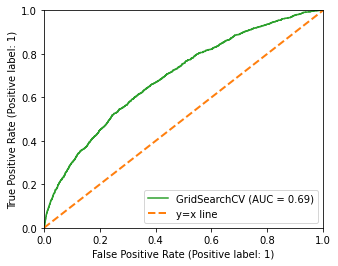

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_roc_curve(model_grid, X_test, y_test, ax=ax, color='C2')
ax.plot([0,1],[0,1], ls="--", lw=2., color="C1", label="y=x line" )
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend()

In [21]:
plot_roc_curve(model_grid, X_test, y_test, ax=ax, color='C2')

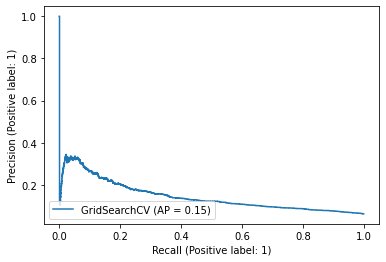

In [28]:
plot_precision_recall_curve(model_grid, X_test, y_test)

## Grid Search CV LR on Bag of Words

In [33]:
subs = ['Superstonks', 'finance', 'options', 'pennystocks', 'GME']

sub = 'GME'
df_sub = df[df['subreddit']==sub]

params = {'penalty': ['l1','l2','None'],
          'C'      : [1, 10, 20]}

model_grid1, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_LR(params, 
                                                                           df=df_sub, 
                                                                           xcol='body_title_author_subreddit',
                                                                           ycol='popular',
                                                                           scorer = "recall",
                                                                           tfidf=False)
                                                                           

Best Score: 0.2933139012630846 {'C': 1, 'penalty': 'l2'}


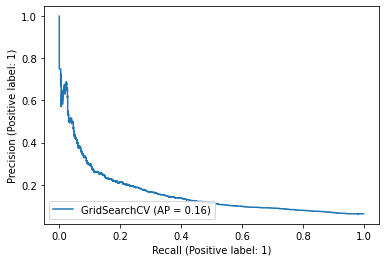

In [34]:
plot_precision_recall_curve(model_grid, X_test, y_test)

In [31]:
subs = ['Superstonks', 'finance', 'options', 'pennystocks', 'GME']

sub = 'GME'
df_sub = df[df['subreddit']==sub]

params = {'penalty': ['l1','l2','None'],
          'C'      : [1, 10, 20]}

model_grid, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_LR(params, 
                                                                           df=df_sub, 
                                                                           xcol='body_title_author_subreddit',
                                                                           ycol='popular',
                                                                           scorer = "precision",
                                                                           tfidf=False)
                                                                           

Best Score: 0.15708803520980527 {'C': 1, 'penalty': 'l2'}


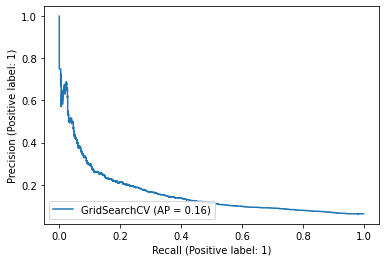

In [32]:
plot_precision_recall_curve(model_grid, X_test, y_test)

BOW: Precision vs Recall


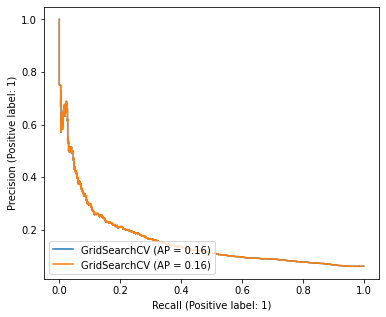

In [36]:
print ("BOW: Precision vs Recall")
fig, ax = plt.subplots(1, 1, figsize=(6,5))
plot_precision_recall_curve(model_grid1, X_test, y_test, ax=ax)
plot_precision_recall_curve(model_grid, X_test, y_test, ax=ax)
plt.show()

In [37]:
#Best Score: 0.40168160736218816 {'C': 1, 'penalty': 'l2'}
subs = ['Superstonks', 'finance', 'options', 'pennystocks', 'GME']

sub = 'GME'
df_sub = df[df['subreddit']==sub]

params = {'penalty': ['l2'],
          'C'      : [1]}

model_grid2, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_LR(params, 
                                                                           df=df_sub, 
                                                                           xcol='body_title_author_subreddit',
                                                                           ycol='popular',
                                                                           scorer = "precision",
                                                                           tfidf=True)
                                                                           

Best Score: 0.16197527218044735 {'C': 1, 'penalty': 'l2'}


BOW: vs TFIDF


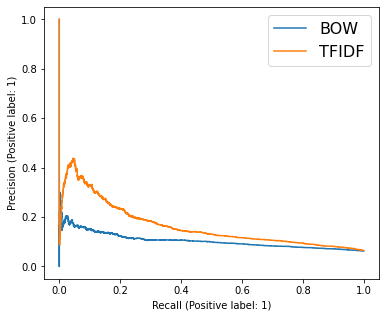

In [43]:
print ("BOW: vs TFIDF")
fig, ax = plt.subplots(1, 1, figsize=(6,5))
plot_precision_recall_curve(model_grid, X_test, y_test, ax=ax, label="BOW")
plot_precision_recall_curve(model_grid2, X_test, y_test, ax=ax, label="TFIDF")
plt.legend(fontsize=16)
plt.show()

## BOW vs TFIDF for all the subs

# PCA  on TFIDF features

In [45]:
params = {'penalty': ['l2', 'l1'],
          'C'      : [1, 5, 10]}

model_grid3, X_train, X_test, y_train, y_test, grid_res = grid_search_CV_LR(params, 
                                                                           df=df, 
                                                                           xcol='body_title_author_subreddit',
                                                                           ycol='popular',
                                                                           scorer = "precision",
                                                                           tfidf=True)
                                                                           

Best Score: 0.206354161060963 {'C': 10, 'penalty': 'l2'}


In [46]:
params = {'penalty': ['l2', 'l1'],
          'C'      : [1, 5, 10]}

model_grid4, X_train, X_test_b, y_train, y_test_b, grid_res = grid_search_CV_LR(params, 
                                                                           df=df, 
                                                                           xcol='body_title_author_subreddit',
                                                                           ycol='popular',
                                                                           scorer = "precision",
                                                                           tfidf=False)
                                                                           

Best Score: 0.18757242723580408 {'C': 1, 'penalty': 'l2'}


In [72]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

print ("TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.")


TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.


In [73]:
tsvd = TruncatedSVD(n_components=10, n_iter=50, random_state=8848)
tsvd.fit(X_train)

TruncatedSVD(n_components=10, n_iter=7, random_state=42)

In [74]:
X_train.shape

(84326, 92984)

In [ ]:
N=10000
tsvd = TruncatedSVD(n_components=N, n_iter=50, random_state=8848)
tsvd.fit(X_train)

In [ ]:
plt.plot(range(1,N+1), np.cumsum(tsvd.explained_variance_ratio_))
plt.xlabel("Number of Components", fontsize=16)
plt.ylabel("Cumulative Explained Variance", fontsize=16)
plt.show()

In [24]:
X_train.shape

(346520, 108976)

In [23]:
tsvd.components_.shape

(10, 108976)

In [ ]:
# PCA on TFIDF features

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

print ("TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.")


tsvd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
tsvd.fit(X_train)

X_train.shape

tsvd.components_.shape

## convert the numerical columns to text columns

In [3]:
import string, re, datetime

def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def hourOfDay(utc):
    return datetime.datetime.utcfromtimestamp(utc).hour

def dayOfWeek(utc):
    return datetime.datetime.utcfromtimestamp(utc).weekday()

def textLength(text):
    return len(text.split())

In [4]:
df_orig = pd.read_csv("df_processed.csv")
df_orig.replace(np.nan, "no_text", inplace=True)

In [5]:
df_orig.columns

Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'subreddit_processed',
       'body_and_title', 'body_and_author', 'title_and_author',
       'body_title_and_author', 'body_title_author_subreddit'],
      dtype='object')

In [6]:
# delete the rows with empty body
df = df_orig[(df_orig.body_processed != 'deleted') & (df_orig.body_processed != 'removed')]
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...
3,3,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,no_text,...,1.0,no_text,standard capital partners solidblock standard ...,fintechinshorts,finance,no_text standard capital partners solidblock s...,no_text fintechinshorts,standard capital partners solidblock standard ...,no_text standard capital partners solidblock s...,no_text standard capital partners solidblock s...


In [7]:
df_superstocks = df[df.subreddit == 'Superstonks']
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

df_superstocks['popular'] = 0
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

df_superstocks.loc[df_superstocks['score'] > np.percentile(df_superstocks.score.values, 95), 'popular'] = 1
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

df = pd.concat([df_superstocks, df_finance, df_options,
                df_pennystocks, df_gme], ignore_index=True)

In [8]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit,popular
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,r superstonk,sub looking r superstonk,seppukkake,superstonks,r superstonk sub looking r superstonk,r superstonk seppukkake,sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukka...,1
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,no_text,https www reddit com r superstonk,fairytalee,superstonks,no_text https www reddit com r superstonk,no_text fairytalee,https www reddit com r superstonk fairytalee,no_text https www reddit com r superstonk fair...,no_text https www reddit com r superstonk fair...,0


In [9]:
df['title_emoji'] = df['title'].apply(emoji_count)
df['body_emoji'] = df['body'].apply(emoji_count)
df['title_length'] = df['title'].apply(textLength)
df['body_length'] = df['body'].apply(textLength)
df['hour'] = df['created'].apply(hourOfDay)
df['day'] = df['created'].apply(dayOfWeek)

In [13]:
cols = ['title_emoji', 'body_emoji', 'title_length', 'body_length', 'hour','day']

In [10]:
from num2words import num2words

In [11]:
def get_num2words(num):
    w = num2words(num)
    w = re.sub(' ', '_', w)
    w = re.sub('-', '_', w)
    return w

get_num2words(21)

'twenty_one'

In [14]:
for col in cols:
    col_new = col+"_w"
    df[col_new] = df[col].apply(get_num2words)

In [15]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,title_length,body_length,hour,day,title_emoji_w,body_emoji_w,title_length_w,body_length_w,hour_w,day_w
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,8,1,9,0,zero,zero,eight,one,nine,zero
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,1,1,10,0,three,zero,one,one,ten,zero


In [16]:
df['bta_sub'] = df['subreddit'].str.lower() + ' ' + df['body_title_and_author']

In [17]:
df['all_joined'] = df['subreddit'].str.lower() + ' ' +df['body_title_and_author'] + ' '+df['title_emoji_w']+' '+df['body_emoji_w']+' '+df['title_length_w']+' '+df['body_length_w']+' '+df['hour_w']+' '+df['day_w'] 


In [18]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,hour,day,title_emoji_w,body_emoji_w,title_length_w,body_length_w,hour_w,day_w,bta_sub,all_joined
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,9,0,zero,zero,eight,one,nine,zero,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,10,0,three,zero,one,one,ten,zero,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...


In [19]:
df1 = df[['popular', 'bta_sub', 'all_joined', 'created']].copy()

# Train test split

In [20]:
df1['posting_time'] = df1['created'].apply(datetime.datetime.fromtimestamp)
df1['posting_month'] = df1['posting_time'].apply(lambda dd: dd.month)
df1.head(2)

,popular,bta_sub,all_joined,created,posting_time,posting_month
0,1,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...,1617613228,2021-04-05 05:00:28,4
1,0,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...,1617619355,2021-04-05 06:42:35,4


In [21]:
df_train = df1[df1['posting_month']<4]
df_test  = df1[df1['posting_month']==4]

In [22]:
df_train.head(2)

,popular,bta_sub,all_joined,created,posting_time,posting_month
120,0,finance no_text mogo establishes atm equity pr...,finance no_text mogo establishes atm equity pr...,1609507913,2021-01-01 08:31:53,1
121,0,finance no_text standard capital partners soli...,finance no_text standard capital partners soli...,1609518689,2021-01-01 11:31:29,1


In [23]:
df_train.shape, df_test.shape

((99226, 6), (27072, 6))

# TFIDF

In [35]:
def train_LR(df_train=df_train,
             df_test=df_test,
             xcol = 'all_joined',
             ycol = 'popular',
             tfidf=True):
    vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)
    #vectorizer = CountVectorizer(max_df=0.95)
    vectorizer.fit(df_train[xcol].values)

    X_train = vectorizer.transform(df_train[xcol].values)
    X_test  = vectorizer.transform(df_test[xcol].values)

    y_train = df_train[ycol].values
    y_test  = df_test[ycol].values
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    return model, X_train, y_train, X_test, y_test, vectorizer

model1, X_train1, y_train1, X_test1, y_test1, vectorizer1 = train_LR(xcol = 'all_joined')

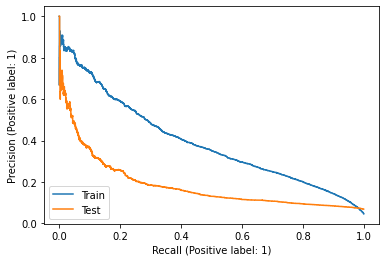

In [36]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
plot_precision_recall_curve(model1, X_train1, y_train1, ax=ax, label="Train")
plot_precision_recall_curve(model1, X_test1, y_test1, ax=ax, label="Test")

In [37]:
model2, X_train2, y_train2, X_test2, y_test2, vectorizer2 = train_LR(xcol = 'bta_sub')

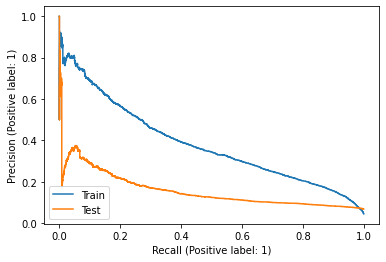

In [38]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
plot_precision_recall_curve(model2, X_train2, y_train2, ax=ax, label="Train")
plot_precision_recall_curve(model2, X_test2, y_test2, ax=ax, label="Test")

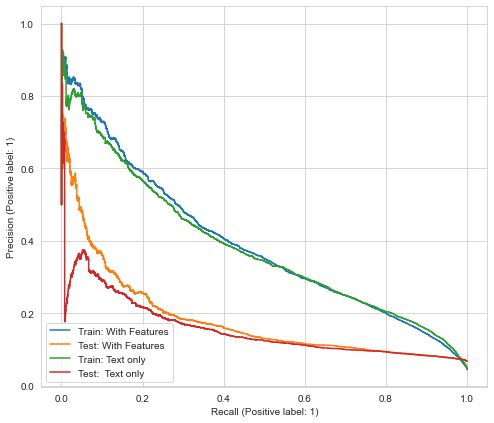

In [41]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(1,1, figsize=(8,7))
plot_precision_recall_curve(model1, X_train1, y_train1, ax=ax, label="Train: With Features")
plot_precision_recall_curve(model1, X_test1, y_test1, ax=ax, label="Test: With Features")
plot_precision_recall_curve(model2, X_train2, y_train2, ax=ax, label="Train: Text only")
plot_precision_recall_curve(model2, X_test2, y_test2, ax=ax, label="Test:  Text only")

In [45]:
y_train1

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
model1.predict_proba(X_train1)

array([[0.98789315, 0.01210685],
       [0.98891054, 0.01108946],
       [0.90490502, 0.09509498],
       ...,
       [0.93273688, 0.06726312],
       [0.9787247 , 0.0212753 ],
       [0.94625003, 0.05374997]])

In [52]:
pr_train, re_train, th_train = precision_recall_curve(y_train1, model1.predict_proba(X_train1)[:,1] )
pr_test, re_test, th_test = precision_recall_curve(y_test1,  model1.predict_proba(X_test1)[:,1] )


In [ ]:
pr_train, re_train, th_train, pr_test, re_test, th_test

In [62]:
pr_train.shape, re_train.shape, th_train.shape

((97211,), (97211,), (97210,))

In [63]:
['pr_train', pr_train],
['re_train', re_train],
['th_train', th_train],
['pr_test', pr_test],
['re_test', re_test],
['th_test', th_test],


In [65]:
pr_re_train = np.stack([pr_train, re_train], axis=1)
pr_re_test  = np.stack([pr_test, re_test], axis=1)


In [66]:
np.savetxt('pr_re_train.dat', pr_re_train)
np.savetxt('pr_re_test.dat', pr_re_test)


In [67]:
f = 'pr_re_train.dat'
dat = np.loadtxt(f)

In [68]:
dat.shape

(97211, 2)

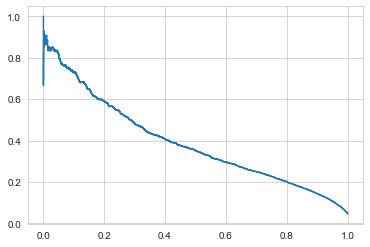

In [71]:
plt.plot(dat[:,1], dat[:,0] )